In [1]:
import json
import pathlib
import pickle
import re

import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
from matplotlib import pyplot as plt

import humanize

import numpy as np
import pandas as pd
import tensorflow as tf
from absl import app
from absl import flags
from absl import logging
from graph_nets.demos import models as gn_models
from graph_nets import utils_np as graph_net_utils_np

from deeplearning.deeptune.opencl.heterogeneous_mapping import utils
from deeplearning.deeptune.opencl.heterogeneous_mapping.models import models
from labm8 import prof
from labm8 import viz

flags.FLAGS(['argv[0]'])

%matplotlib inline

/home/cec/.cache/bazel/_bazel_cec/d1665aef25bbeeb91c01df7ddc90dba7/execroot/phd/bazel-out/k8-opt/bin/docs/wip_graph/notebooks/notebooks.runfiles/pypi__h5py_2_7_1/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Read experimental data

Run training with:

```sh
rm -rf /tmp/phd/docs/wip_graph/train_model && bazel run //docs/wip_graph/notebooks:04_train_model -- --v=1 --df=/var/phd/shared/docs/wip_graph/lda_opencl_device_mapping_dataset.pkl --outdir=/tmp/phd/docs/wip_graph/train_model --num_epochs=2 --experimental_force_num_processing_steps=10 --experimental_maximum_split_count=2
```

Use tensorboard with:

```sh
python -m tensorboard.main --logdir='/tmp/phd/docs/wip_graph/train_model/tensorboard'
```

In [2]:
LDA_OUTDIR = pathlib.Path('/var/phd/shared/docs/wip_graph/c')
!ls {LDA_OUTDIR}

predictions.pkl  telemetry  tensorboard  values


In [4]:
def ReadTelemetryFiles(outdir: pathlib.Path):
    logs = []
    for json_file in (outdir / 'telemetry').iterdir():
        with open(json_file) as f:
            log = json.load(f)
        logs.append(log)
        del log['test_outputs']  # We don't need tests outputs at the moment.
        log['training_loss'] = sum(log['training_losses']) / len(log['training_losses'])
    return pd.DataFrame(logs).sort_values(by=['epoch',])

df = ReadTelemetryFiles(LDA_OUTDIR)
df['group'] = 'foo'
df

,batch_runtime_ms,batch_size,epoch,initial_learning_rate,learning_rate,learning_rate_exponential_decay,num_processing_steps,test_accuracy,test_graph_count,test_graphs_per_second,...,training_graph_count,training_graphs_per_second,training_loss,training_losses,validation_accuracy,validation_graph_count,validation_graphs_per_second,validation_loss,validation_runtime_ms,group
81,"[36400, 1347, 1162, 771, 837, 787, 388]",64,1,0.001,0.001000,0.99,50,0.449275,69,13.587234,...,407,57.731594,0.722136,"[0.8257302045822144, 0.7249957323074341, 0.741...",0.617647,204,30.792676,0.630933,6624.952078,foo
120,"[731, 1138, 1162, 780, 1131, 1096, 431]",64,2,0.001,0.000990,0.99,50,0.449275,69,93.656457,...,407,64.151210,0.726539,"[0.6348611116409302, 0.8494765758514404, 0.758...",0.617647,204,104.586828,0.633192,1950.532436,foo
96,"[909, 741, 1139, 1706, 1147, 1241, 374]",64,3,0.001,0.000980,0.99,50,0.449275,69,83.959989,...,407,59.861920,0.692454,"[0.8003025054931641, 0.5603243112564087, 0.708...",0.617647,204,99.724955,0.640856,2045.626402,foo
33,"[1052, 1016, 953, 1192, 951, 976, 246]",64,4,0.001,0.000970,0.99,50,0.449275,69,81.938903,...,407,67.259991,0.681290,"[0.6707007884979248, 0.6846781969070435, 0.674...",0.617647,204,66.181994,0.670565,3082.409382,foo
48,"[846, 882, 919, 1114, 842, 1178, 542]",64,5,0.001,0.000961,0.99,50,0.449275,69,83.104775,...,407,63.969117,0.685957,"[0.6741862893104553, 0.6851740479469299, 0.677...",0.617647,204,84.988295,0.657328,2400.330544,foo
126,"[974, 1076, 1126, 930, 1336, 843, 386]",64,6,0.001,0.000951,0.99,50,0.449275,69,89.207721,...,407,61.994630,0.674558,"[0.6751834154129028, 0.6881925463676453, 0.645...",0.617647,204,110.501377,0.645563,1846.130848,foo
174,"[993, 872, 866, 2289, 1009, 1029, 398]",64,7,0.001,0.000941,0.99,50,0.449275,69,86.729526,...,407,60.415182,0.674314,"[0.6431388854980469, 0.6946295499801636, 0.690...",0.617647,204,102.128382,0.637069,1997.485876,foo
154,"[1051, 1069, 807, 850, 755, 1292, 464]",64,8,0.001,0.000932,0.99,50,0.449275,69,73.643094,...,407,65.576768,0.667263,"[0.6986538171768188, 0.6633915901184082, 0.693...",0.617647,204,64.267775,0.636966,3174.219131,foo
159,"[1064, 1007, 1066, 1127, 1025, 696, 329]",64,9,0.001,0.000923,0.99,50,0.449275,69,38.016917,...,407,66.359140,0.676060,"[0.6568542718887329, 0.7384040951728821, 0.687...",0.617647,204,95.757858,0.636265,2130.373478,foo
156,"[1035, 1072, 823, 827, 1016, 1290, 438]",64,10,0.001,0.000914,0.99,50,0.449275,69,78.572335,...,407,63.079011,0.679286,"[0.678297758102417, 0.642022967338562, 0.68591...",0.617647,204,100.648613,0.638591,2026.853561,foo


### Loss

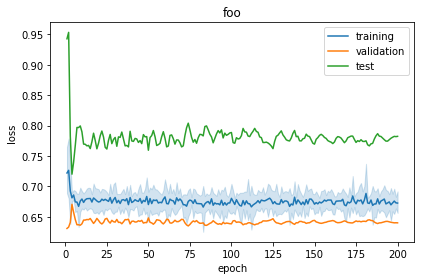

In [5]:
def TableOfAllTrainingLosses(df: pd.DataFrame):
    losses = []
    for _, row in df.iterrows():
        for loss in row['training_losses']:
            losses.append({
                'epoch': row['epoch'],
                'group': row['group'],
                'loss': loss,
            })
    return pd.DataFrame(losses)

groups = sorted(set(df['group']))
for i, group in enumerate(groups):
    df_to_plot = df[df['group'] == group]
    sns.lineplot('epoch', 'loss', data=TableOfAllTrainingLosses(df_to_plot), label='training')
    sns.lineplot('epoch', 'validation_loss', data=df_to_plot, label='validation')
    sns.lineplot('epoch', 'test_loss', data=df_to_plot, label='test')
    plt.ylabel('loss')
    plt.legend()
    plt.title(group)
    viz.finalise()

### Accuracy

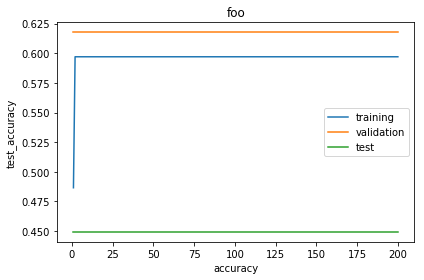

In [6]:
groups = sorted(set(df['group']))
for i, group in enumerate(groups):
    df_to_plot = df[df['group'] == group]
    sns.lineplot('epoch', 'training_accuracy', data=df_to_plot, label='training')
    sns.lineplot('epoch', 'validation_accuracy', data=df_to_plot, label='validation')
    sns.lineplot('epoch', 'test_accuracy', data=df_to_plot, label='test')
    plt.xlabel('accuracy')
    plt.title(group)
    viz.finalise()